This notebook is based on notebook 1, but using softmax as last activation instead of sigmoid.  
Following adaptations were needed:
- Data Generator: Set class_mode='categorical' to use one-hot encoding.
- Model Output Layer: Use Dense(2, activation='softmax') for two classes.
- Loss Function: Use categorical_crossentropy for multi-class classification.
- Difference in constructing the confusion matrix and the classification report.
- SHAP result seem more unclear.

Background:
The sigmoid function outputs a value between 0 and 1, which can be interpreted as the probability that the input belongs to one class (usually class 1).
In binary classification, softmax will output two values, one for each class. 
Each value is the probability of the input belonging to that class, with both outputs summing to 1.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import shap
from datetime import datetime
start_time = datetime.now()
print(os.listdir("input"))

tf.random.set_seed(11)
np.random.seed(11)
import random
random.seed(11)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.config.experimental.enable_op_determinism()

['chest_xray']


In [2]:
#defining folder parameters #print(mainDIR)
mainDIR = os.listdir('input/chest_xray/chest_xray')
train_folder= 'input/chest_xray/chest_xray/train/'
val_folder = 'input/chest_xray/chest_xray/val/'
test_folder = 'input/chest_xray/chest_xray/test/'
train_n = train_folder+'NORMAL/'
train_p = train_folder+'PNEUMONIA/'
val_n = val_folder+'NORMAL/'
val_p = val_folder+'PNEUMONIA/'
test_n = test_folder+'NORMAL/'
test_p = test_folder+'PNEUMONIA/'

print("nbr of normal pictures in trainingset: " + str(len(os.listdir(train_n))))
print("nbr of sick pictures in trainingset: " + str(len(os.listdir(train_p))))
print("nbr of normal pictures in testset: " + str(len(os.listdir(test_n))))
print("nbr of sick pictures in testset: " + str(len(os.listdir(test_p))))
print("nbr of normal pictures in validationset: " + str(len(os.listdir(val_n))))
print("nbr of sick pictures in validationset: " + str(len(os.listdir(val_p))))

nbr of normal pictures in trainingset: 1342
nbr of sick pictures in trainingset: 3876
nbr of normal pictures in testset: 234
nbr of sick pictures in testset: 390
nbr of normal pictures in validationset: 9
nbr of sick pictures in validationset: 9


random normal picture :  NORMAL2-IM-1096-0001.jpeg
random sick picture : person1504_virus_2614.jpeg
Normal Image Size: (1580, 1329)
Pneumonia Image Size: (1088, 776)
Image Mode normal image: L
Image Mode sick image: L


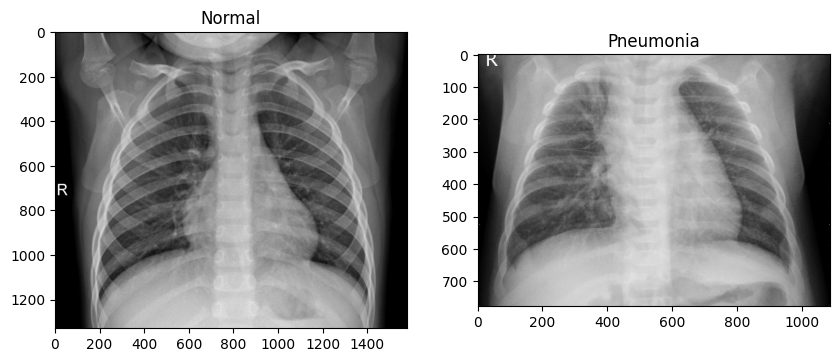

In [3]:
# analysing random training data #
# Normal pic 
rand_norm= np.random.randint(0,len(os.listdir(train_n)))
norm_pic = os.listdir(train_n)[rand_norm]
print('random normal picture : ',norm_pic)
norm_pic_address = train_n+norm_pic
norm_load = Image.open(norm_pic_address)
f = plt.figure(figsize= (10,6))
a1 = f.add_subplot(1,2,1)
img_plot = plt.imshow(norm_load, cmap='gray')
a1.set_title('Normal')
#Pneumonia 
rand_p = np.random.randint(0,len(os.listdir(train_p)))
sic_pic =  os.listdir(train_p)[rand_norm]
sic_address = train_p+sic_pic
print('random sick picture :', sic_pic)
sic_load = Image.open(sic_address)
a2 = f.add_subplot(1, 2, 2)
img_plot = plt.imshow(sic_load, cmap='gray')
a2.set_title('Pneumonia');
# Size
print("Normal Image Size:", norm_load.size)  # Output (width, height)
print("Pneumonia Image Size:", sic_load.size)
# Get mode (color format) # L is one channel
print("Image Mode normal image:", norm_load.mode) 
print("Image Mode sick image:", sic_load.mode)

In [4]:
folder_path =(train_n, train_p, val_n, val_p, test_n, test_p)
widths = []
heights = []
for i in folder_path:
    for filename in os.listdir(i):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):  # Check for image files
            img_path = os.path.join(i, filename)
            with Image.open(img_path) as img:
                width, height = img.size  # Get image size
                widths.append(width)
                heights.append(height)
    avg_width = np.mean(widths)
    avg_height = np.mean(heights)
    print(f"Average Image Size in {i}: {avg_width:.2f} x {avg_height:.2f} pixels (Aspect Ratio: {avg_width/avg_height:.2f})")

Average Image Size in input/chest_xray/chest_xray/train/NORMAL/: 1667.73 x 1381.43 pixels (Aspect Ratio: 1.21)
Average Image Size in input/chest_xray/chest_xray/train/PNEUMONIA/: 1320.61 x 968.07 pixels (Aspect Ratio: 1.36)
Average Image Size in input/chest_xray/chest_xray/val/NORMAL/: 1320.85 x 968.42 pixels (Aspect Ratio: 1.36)
Average Image Size in input/chest_xray/chest_xray/val/PNEUMONIA/: 1320.70 x 968.18 pixels (Aspect Ratio: 1.36)
Average Image Size in input/chest_xray/chest_xray/test/NORMAL/: 1341.23 x 985.34 pixels (Aspect Ratio: 1.36)
Average Image Size in input/chest_xray/chest_xray/test/PNEUMONIA/: 1327.88 x 970.69 pixels (Aspect Ratio: 1.37)


In [5]:
#mageDataGenerator augments your image by iterating through image
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 1,
                                   zoom_range = 0.2,
                                   horizontal_flip = False) 

training_set = train_datagen.flow_from_directory(train_folder,
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 color_mode='grayscale',
                                                 seed = 11,
                                                 shuffle=True,
                                                 class_mode = 'categorical')

rescaled_set = ImageDataGenerator(rescale = 1./255) #Image normalization

validation_generator = rescaled_set.flow_from_directory(val_folder,
    target_size=(64, 64),
    batch_size=32,
    color_mode='grayscale',
    class_mode='categorical')

test_set = rescaled_set.flow_from_directory(test_folder,
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            color_mode='grayscale',
                                            class_mode = 'categorical',
                                            shuffle=False)  # Ensure consistency

print(validation_generator.class_indices)
print(training_set.class_indices)
print(test_set.class_indices)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}


In [6]:
input_shape = (64, 64, 1)  
cnn = Sequential()
cnn.add(Input(shape = input_shape))
cnn.add(Conv2D(32, (3, 3), activation="relu"))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu"))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Flatten())
cnn.add(Dropout(0.2))
#cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'softmax', units = 2))
cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy', Precision(), Recall(), AUC()])
cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │        12,546 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,114 (86.38 KB)

 Trainable params: 22,114 (86.38 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Define early stopping
early_stop = EarlyStopping(
    monitor='val_loss',  # Stop when validation loss stops improving --- 'val_auc'
    patience=5,  # Number of epochs to wait before stopping
    restore_best_weights=True  # Restore the best model weights
)
# Train the model with early stopping
cnn_model = cnn.fit(
    training_set,
    epochs=50,  # Set a high number, but training will stop early if needed
    validation_data=validation_generator,
    callbacks=[early_stop]  # Attach early stopping
)

c:\repos\Computer_vision\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 24s 139ms/step - accuracy: 0.7549 - auc: 0.8211 - loss: 0.5040 - precision: 0.7549 - recall: 0.7549 - val_accuracy: 0.8125 - val_auc: 0.8672 - val_loss: 0.4926 - val_precision: 0.8125 - val_recall: 0.8125
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 22s 135ms/step - accuracy: 0.8921 - auc: 0.9639 - loss: 0.2451 - precision: 0.8921 - recall: 0.8921 - val_accuracy: 0.8750 - val_auc: 0.9062 - val_loss: 0.4238 - val_precision: 0.8750 - val_recall: 0.8750
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 143ms/step - accuracy: 0.9059 - auc: 0.9695 - loss: 0.2236 - precision: 0.9059 - recall: 0.9059 - val_accuracy: 0.6250 - val_auc: 0.7891 - val_loss: 0.6982 - val_precision: 0.6250 - val_recall: 0.6250
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 142ms/step - accuracy: 0.9241 - auc: 0.9756 - loss: 0.1997 - precision: 0.9241 - recall: 0.9241 - val_accuracy: 0.7500 - val_auc: 0.8516 - val_loss: 0.5054 - val_precision: 0.7500 - val_recall: 0.7500
Epoch 5/50
163/163 ━

In [8]:
print(cnn_model.history.keys())

dict_keys(['accuracy', 'auc', 'loss', 'precision', 'recall', 'val_accuracy', 'val_auc', 'val_loss', 'val_precision', 'val_recall'])


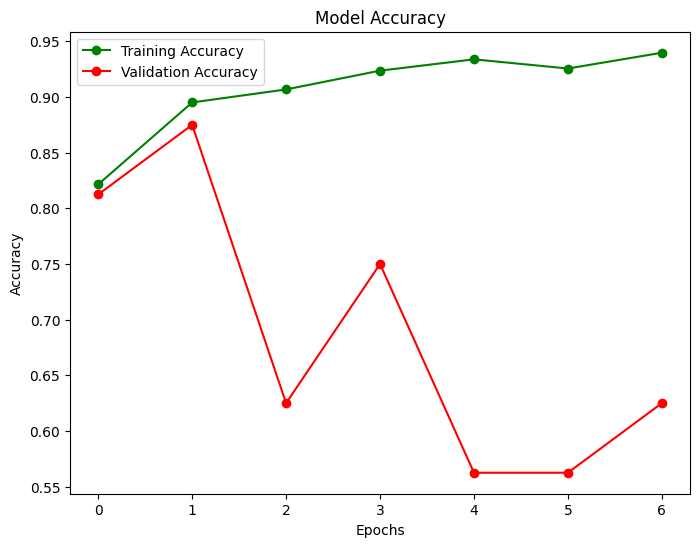

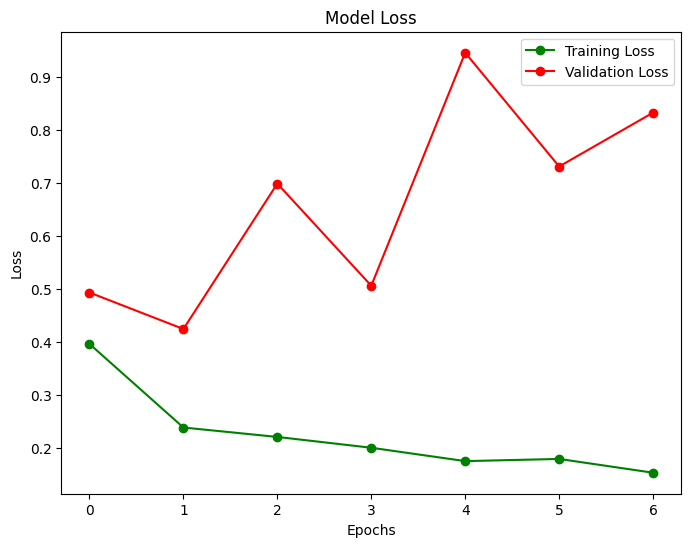

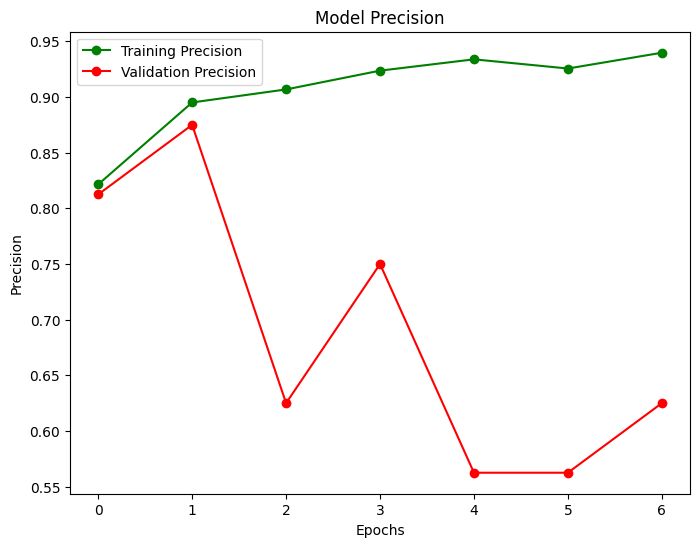

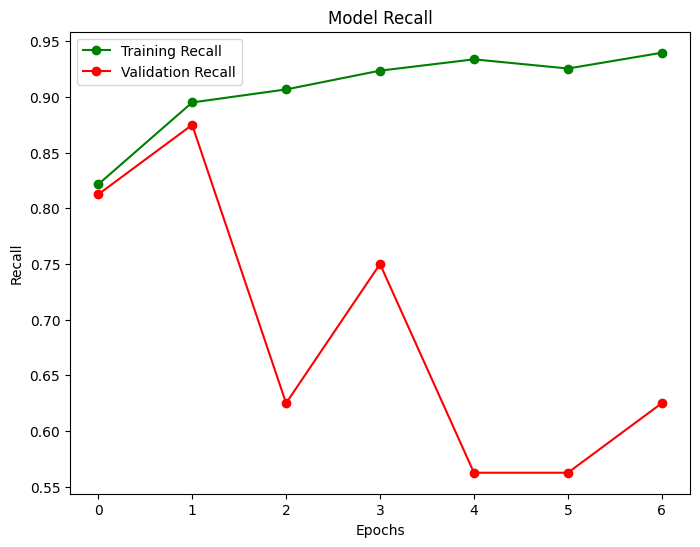

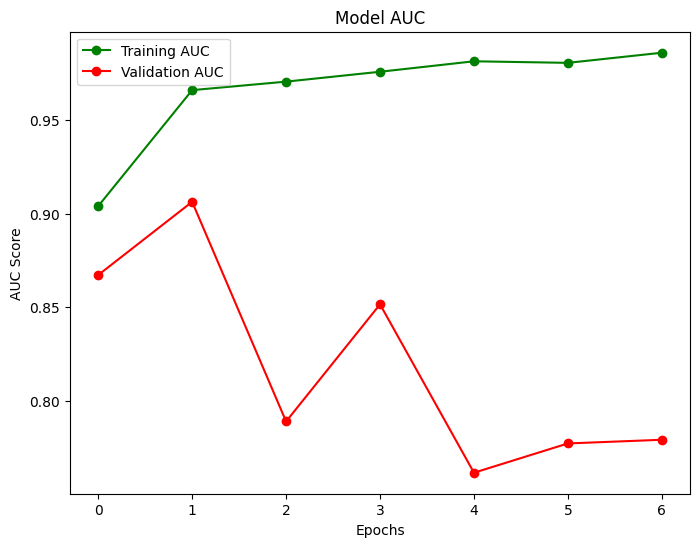

In [9]:
# Plot Accuracy
plt.figure(figsize=(8,6))
plt.plot(cnn_model.history['accuracy'], 'go-', label='Training Accuracy')
plt.plot(cnn_model.history['val_accuracy'], 'ro-', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
# Plot Loss
plt.figure(figsize=(8,6))
plt.plot(cnn_model.history['loss'], 'go-', label='Training Loss')
plt.plot(cnn_model.history['val_loss'], 'ro-', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
# Plot Precision
plt.figure(figsize=(8,6))
plt.plot(cnn_model.history['precision'], 'go-', label='Training Precision')
plt.plot(cnn_model.history['val_precision'], 'ro-', label='Validation Precision')
plt.title('Model Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()
# Plot Recall
plt.figure(figsize=(8,6))
plt.plot(cnn_model.history['recall'], 'go-', label='Training Recall')
plt.plot(cnn_model.history['val_recall'], 'ro-', label='Validation Recall')
plt.title('Model Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()
# Plot AUC
plt.figure(figsize=(8,6))
plt.plot(cnn_model.history['auc'], 'go-', label='Training AUC')
plt.plot(cnn_model.history['val_auc'], 'ro-', label='Validation AUC')
plt.title('Model AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC Score')
plt.legend()
plt.show()

In [10]:
loss, accuracy, precision, recall, auc = cnn.evaluate(test_set)
print(f"Test Loss: {loss:.2f}")
print(f"Test Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"AUC: {auc:.2f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.7639 - auc: 0.8343 - loss: 0.5008 - precision: 0.7639 - recall: 0.7639
Test Loss: 0.33
Test Accuracy: 0.85
Precision: 0.85
Recall: 0.85
AUC: 0.93


In [11]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Get predicted labels
prediction = cnn.predict(test_set)  # Predict on test set
np.set_printoptions(suppress=True)  # Set print options to suppress scientific notation
prediction


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step


array([[0.7123392 , 0.28766075],
       [0.6464059 , 0.3535941 ],
       [0.18187329, 0.8181267 ],
       ...,
       [0.00946863, 0.9905314 ],
       [0.03921178, 0.9607882 ],
       [0.19439603, 0.8056039 ]], dtype=float32)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step
Confusion Matrix:
 [[156  78]
 [ 13 377]]


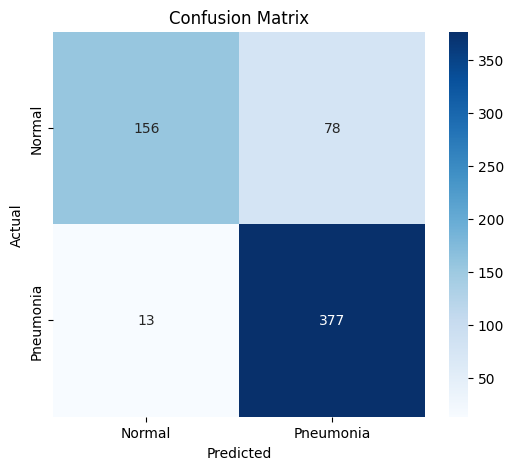

In [12]:
# confusion matrix
# Get the actual class labels
y_true = test_set.classes  # One-hot labels will automatically be in class indices (0 or 1)
# Get the predicted probabilities and convert them into class labels (0 or 1)
y_pred_prob = cnn.predict(test_set)  # Output from the model, probabilities for each class
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class labels (0 or 1)

cm = confusion_matrix(y_true, y_pred)# Compute the confusion matrix
print("Confusion Matrix:\n", cm)# Print the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show() # Plot the confusion matrix


In [13]:
print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.92      0.67      0.77       234
   Pneumonia       0.83      0.97      0.89       390

    accuracy                           0.85       624
   macro avg       0.88      0.82      0.83       624
weighted avg       0.86      0.85      0.85       624



c:\repos\Computer_vision\.venv\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(1, 64, 64, 1))']
  warnings.warn(msg)
c:\repos\Computer_vision\.venv\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 64, 64, 1))']
  warnings.warn(msg)


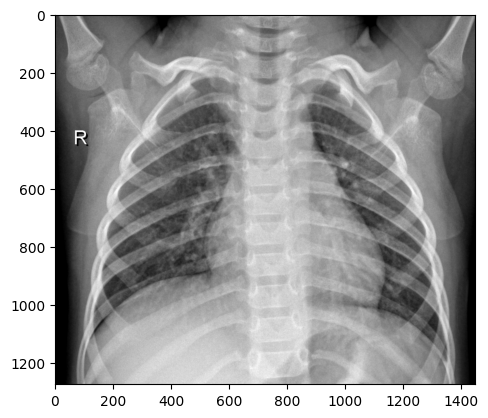

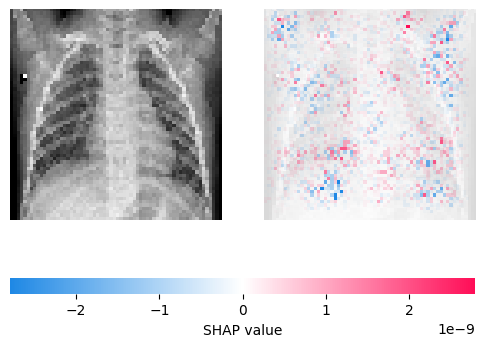

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Prediction Probabilities: [0.9813969  0.01860311]
Predicted Class: Normal


In [14]:
rand_norm= np.random.randint(0,len(os.listdir(train_n)))
norm_pic = os.listdir(train_n)[rand_norm]

image_path = train_n+norm_pic
load = Image.open(image_path)
img_plot = plt.imshow(load, cmap='gray')
img = load_img(image_path, target_size=(64, 64), color_mode="grayscale")  
img_array = img_to_array(img) / 255.0  
img_array = np.expand_dims(img_array, axis=0)  

# SHAP
background = np.random.randn(10, 64, 64, 1)  # Generate background samples of the same shape
explainer = shap.GradientExplainer(cnn, background)
shap_values = explainer.shap_values(img_array)  # img_array shape: (1, 64, 64, 1)
shap.image_plot(shap_values, img_array)
prediction = cnn.predict(img_array)[0]  # Model output (array with two probabilities)
predicted_class_index = np.argmax(prediction)  # Get the index of the highest probability
predicted_class = "Pneumonia" if predicted_class_index == 1 else "Normal"

print(f"Prediction Probabilities: {prediction}")
print(f"Predicted Class: {predicted_class}")

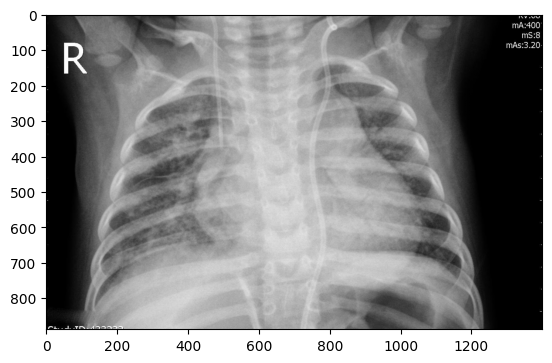

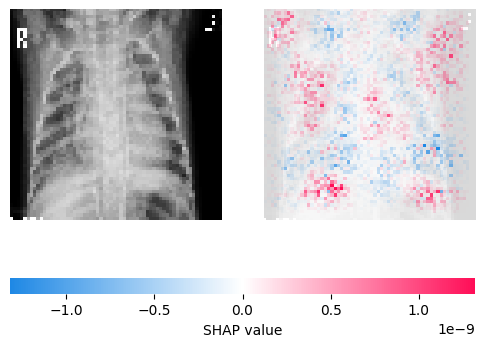

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Prediction Probabilities: [0.0015745 0.9984255]
Predicted Class: Pneumonia


In [15]:
rand_norm= np.random.randint(0,len(os.listdir(train_p)))
sic_pic = os.listdir(train_p)[rand_norm]

image_path = train_p+sic_pic
load = Image.open(image_path)
img_plot = plt.imshow(load, cmap='gray')
img = load_img(image_path, target_size=(64, 64), color_mode="grayscale")  
img_array = img_to_array(img) / 255.0  
img_array = np.expand_dims(img_array, axis=0)  

# SHAP
background = np.random.randn(10, 64, 64, 1)  # Generate background samples of the same shape
explainer = shap.GradientExplainer(cnn, background)
shap_values = explainer.shap_values(img_array)  # img_array shape: (1, 64, 64, 1)
shap.image_plot(shap_values, img_array)
prediction = cnn.predict(img_array)[0]  # Model output (array with two probabilities)
predicted_class_index = np.argmax(prediction)  # Get the index of the highest probability
predicted_class = "Pneumonia" if predicted_class_index == 1 else "Normal"

print(f"Prediction Probabilities: {prediction}")
print(f"Predicted Class: {predicted_class}")

In [16]:
end_time = datetime.now()
duration = end_time - start_time
full_minutes = duration.seconds // 60  # Full minutes
remaining_seconds = duration.seconds % 60  # Remainder in seconds
print(end_time)
print(f"Duration: {full_minutes} minutes and {remaining_seconds} seconds")

2025-02-07 10:12:45.446469
Duration: 2 minutes and 54 seconds
